In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


In [2]:
# Imported Interbank FX Rates Historical.csv
Interbank_FX_Rates_Historical = pd.read_csv('./datasets/Interbank FX Rates Historical.csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns GBPGHS
Interbank_FX_Rates_Historical.rename(columns={'Selling': 'GBPGHS'}, inplace=True)

In [3]:
# Imported Interbank FX Rates Historical (1).csv
Interbank_FX_Rates_Historical_1 = pd.read_csv('./datasets/Interbank FX Rates Historical (1).csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical_1.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns USDGHS
Interbank_FX_Rates_Historical_1.rename(columns={'Selling': 'USDGHS'}, inplace=True)

In [4]:
# Merged Interbank_FX_Rates_Historical_1 and Interbank_FX_Rates_Historical into df3
temp_df = Interbank_FX_Rates_Historical.drop_duplicates(subset=['Date']) # Remove duplicates so lookup merge only returns first match
df = Interbank_FX_Rates_Historical_1.merge(temp_df, left_on=['Date'], right_on=['Date'], how='left', suffixes=['_Interbank_FX_Rates_Historical_1', '_Interbank_FX_Rates_Historical'])
df.head()

,Date,USDGHS,GBPGHS
0,31 Dec 2020,7.8787,5.7631
1,30 Dec 2020,7.8087,5.7371
2,29 Dec 2020,7.7383,5.7351
3,24 Dec 2020,7.7779,5.7351
4,23 Dec 2020,7.7344,5.7241


In [5]:
# Check for missing values
print('missing values:', df.isnull().sum().sort_values(ascending = False))

missing values: Date      0
USDGHS    0
GBPGHS    0
dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3226 entries, 0 to 3225
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3226 non-null   object
 1   USDGHS  3226 non-null   object
 2   GBPGHS  3226 non-null   object
dtypes: object(3)
memory usage: 100.8+ KB


In [7]:
df['USDGHS'] = pd.to_numeric(df['USDGHS'], errors='coerce')
df['GBPGHS'] = pd.to_numeric(df['GBPGHS'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
# Resample the DataFrame to a daily frequency and forward-fill missing values
df = df.resample('D').ffill()
df = df.fillna(method='bfill')
df.describe()

,USDGHS,GBPGHS
count,4748.000000,4748.000000
mean,4.320325,3.040635
std,1.846412,1.547481
min,0.000000,0.000000
25%,2.454700,1.522400
50%,4.878600,3.011850
75%,5.922800,4.404125
max,7.878700,5.763100


In [8]:
df_plot = df.copy()
df.head()

,USDGHS,GBPGHS
Date,,
2008-01-02,1.9427,0.9799
2008-01-03,1.9394,0.9799
2008-01-04,1.9309,0.9798
2008-01-05,1.9309,0.9798
2008-01-06,1.9309,0.9798


<AxesSubplot:xlabel='Date'>

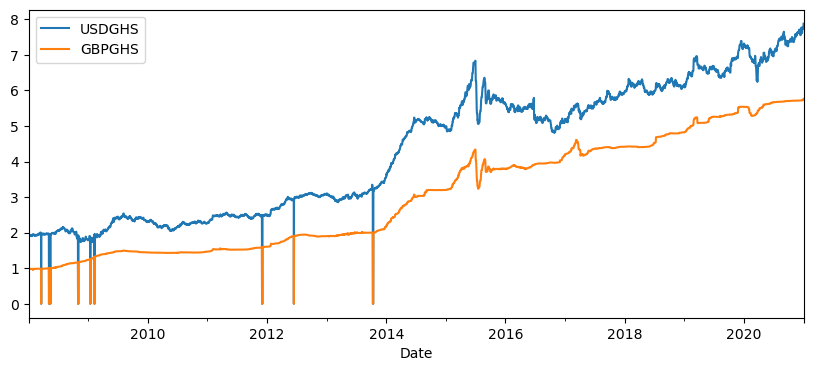

In [9]:
# Let's see a historical view of the closing price
df_plot['USDGHS'].plot(legend=True, figsize=(10,4))
df_plot['GBPGHS'].plot(legend=True, figsize=(10,4))

In [10]:
# Let's go ahead and plot out several moving averages
MA_day = [10,50,200]

for ma in MA_day:
    column_name = 'MA for %s days' %(str(ma))
    df_plot[column_name] = df_plot['USDGHS'].rolling(window=ma).mean()


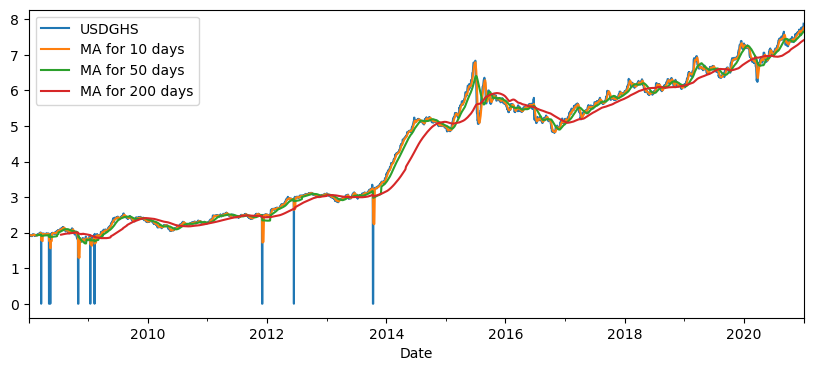

In [11]:
df_plot = df_plot[['USDGHS','MA for 10 days','MA for 50 days','MA for 200 days']].plot(subplots=False,figsize=(10,4))

In [12]:
USDGHS = df['USDGHS']
USDGHS.head()

Date
2008-01-02    1.9427
2008-01-03    1.9394
2008-01-04    1.9309
2008-01-05    1.9309
2008-01-06    1.9309
Freq: D, Name: USDGHS, dtype: float64

It is not necessary to check for autocorrelation in time series before using LSTM. However, it is important to check for autocorrelation in time series data before using any time series model. Autocorrelation is a measure of the correlation between the values of a time series at different points in time. If there is autocorrelation in the data, it means that the values of the time series at one point in time are correlated with the values at other points in time. This can lead to biased estimates of the model parameters and can affect the accuracy of the model predictions

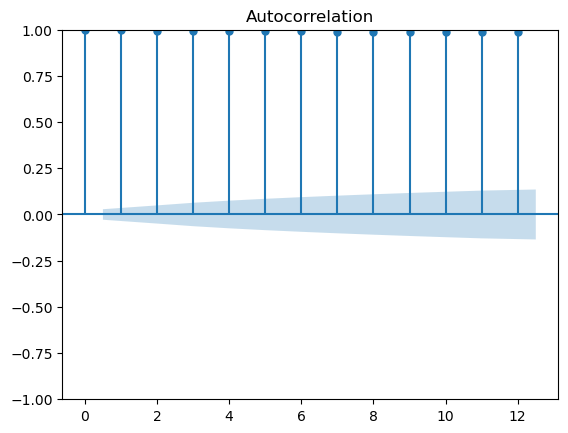

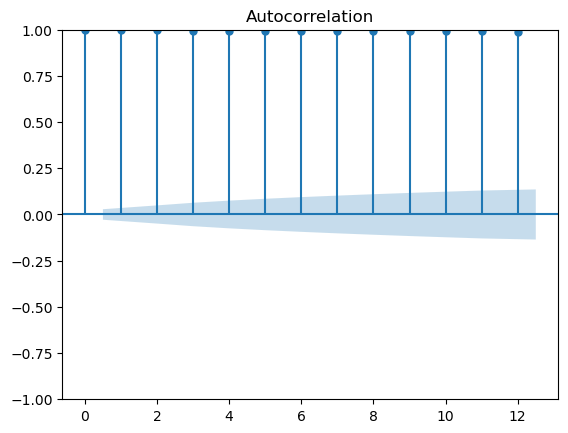

In [13]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(df["USDGHS"], lags=12)
fig = tsaplots.plot_acf(df["GBPGHS"], lags=12)
plt.show()

In [14]:
print('the shape of the  dataset is ', USDGHS.shape)

the shape of the  dataset is  (4748,)


### Transforming the time series into well labelled training and testing dataset 

We will use the following function to transform time series into well labelled braining training and target samples. i.e we transform out input into a tuple (n_samples,n_timesteps,n_features)

In [15]:
def Model_data_setup(data, lookback, delay, min_index, max_index):
    """
    data:     Shape (n_samples, n_features). First column is the time series, other columns are the features.
              If there is only one column, it is assumed to be the time series data.
    lookback: Number of time steps in the Model >= 1
    delay:    The number of time steps to predict >= 1.
    min_index,max_index: The starting and ending indices of the time series portion to construct the data.
                         Allows constructing validation and test sets from the series in proper shape
    Returns: A tuple (x, y) of numpy arrays where x is in shape (n_samples, n_timesteps, n_features) and 
             y is in shape (n_samples, delay). y is an array of target arrays each of size delay. To forecast 
             a single value n timesteps ahead, set delay = n and take the last element of the forecast array.
    """
    if data.ndim == 1:
        data = np.expand_dims(data, axis=1)
    n_samples = max_index - lookback - delay + 1
    x_shape = (n_samples, lookback, data.shape[1])
    x = np.zeros(x_shape)
    y_shape = (n_samples, delay)
    y = np.zeros(y_shape)

    for i in range(n_samples):
        start_index = i + min_index
        end_index = start_index + lookback
        x[i,:,:] = data[start_index:end_index,:]
        y[i,:] = data[end_index + delay - 1, 0]

    return x, y


In [16]:
xdata, ydata = Model_data_setup(USDGHS.values, lookback=5, delay=1, min_index=0, max_index=len(USDGHS)-1)


### Splitting the dataset into the training and testing sets

We are splitting the dataset of normalized stock prices into 80$\%$ and 20$\%$ for training and testing respectively. 20 $\%$ of training set will be assigned for validation at later stage.

In [17]:
#Specifying the sizes of training and testing datasets.
train_size = int(len(xdata)*0.6) # 2416#
valid_size = int(len(xdata)*0.2) #605#
test_size = len(xdata) - train_size-valid_size #355#

#Splitting the dataset into trainig, validation and testing.
xtrain, xvalid, xtest = xdata[0:train_size,:], xdata[train_size:train_size+valid_size,:], xdata[train_size+valid_size:len(xdata),:]
ytrain, yvalid, ytest = ydata[0:train_size,:], ydata[train_size:train_size+valid_size,:], ydata[train_size+valid_size:len(ydata),:]

print('The shape of the training sample is: ', xtrain.shape)
print('The shape of the validation sample is: ', xvalid.shape)
print('The shape of the testing sample is: ', xtest.shape)
print('The shape of the training target is: ', ytrain.shape)
print('The shape of the validation target is: ', yvalid.shape)
print('The shape of the testing target is: ', ytest.shape)

The shape of the training sample is:  (2845, 5, 1)
The shape of the validation sample is:  (948, 5, 1)
The shape of the testing sample is:  (949, 5, 1)
The shape of the training target is:  (2845, 1)
The shape of the validation target is:  (948, 1)
The shape of the testing target is:  (949, 1)


In [18]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], -1))
xvalid = np.reshape(xvalid, (xvalid.shape[0], xvalid.shape[1], -1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], -1))


## Neural Networks Models

In [138]:
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM,GRU,Conv1D, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


The RNNs have a feedback mechanism that allows them to take into account the previous inputs in the sequence while making predictions. This feedback loop creates a kind of memory within the network, which is why RNNs are well-suited for sequential data. The mathematical representation of an RNN is:

\begin{equation}
h_t = f(W_{hh}h_{t-1} + W_{xh}x_t + b_h)
\end{equation}

where $h_t$ is the hidden state at time $t$, $x_t$ is the input at time $t$, $W_{hh}$ is the weight matrix for the hidden-to-hidden connections, $W_{xh}$ is the weight matrix for the input-to-hidden connections, $b_h$ is the bias term, and $f$ is an activation function.



LSTM networks are a type of RNN that are designed to address the vanishing gradient problem that can occur in traditional RNNs. LSTM networks use memory cells and gates to selectively remember or forget information from previous inputs. The mathematical representation of an LSTM network is:

\begin{align}
f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
o_t &= \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
\tilde{C}t &= \tanh(W_C \cdot [h{t-1}, x_t] + b_C) \\
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \\
h_t &= o_t * \tanh(C_t)
\end{align}

where $f_t$ is the forget gate, $i_t$ is the input gate, $o_t$ is the output gate, $\tilde{C}_t$ is the candidate cell state, $C_t$ is the cell state, and $h_t$ is the hidden state. $W_f$, $W_i$, $W_o$, and $W_C$ are the weight matrices, and $b_f$, $b_i$, $b_o$, and $b_C$ are the bias terms. $\sigma$ is the sigmoid activation function, and $\tanh$ is the hyperbolic tangent activation function.

Let's consider a sequence of two-dimensional data, represented as a tensor $X$ of shape $(num_timesteps, height, width, channels)$. At each time step $t$, the input $X[t]$ is processed by a ConvLSTM cell, which consists of several operations.

First, the cell applies a convolution operation to the input $X[t]$ and the previous hidden state $H[t-1]$, with a set of filters $W_x$ and $W_h$, respectively. The output of this convolution is a set of feature maps $F[t]$:

$$F[t] = \text{Conv}(X[t], W_x) + \text{Conv}(H[t-1], W_h)$$

Next, the cell applies several gating mechanisms to control the flow of information through the network. Specifically, it computes three gates: the input gate $i[t]$, the forget gate $f[t]$, and the output gate $o[t]$:

\begin{align*}
i[t] &= \sigma(\text{Conv}(X[t], W_i) + \text{Conv}(H[t-1], U_i)) \\
f[t] &= \sigma(\text{Conv}(X[t], W_f) + \text{Conv}(H[t-1], U_f)) \\
o[t] &= \sigma(\text{Conv}(X[t], W_o) + \text{Conv}(H[t-1], U_o))
\end{align*}

where $\sigma$ represents the sigmoid activation function, and $W_i$, $W_f$, $W_o$, $U_i$, $U_f$, and $U_o$ are the weights for the convolutional filters used to compute each gate.

These gates control which information is passed through the cell, and which information is discarded. The input gate $i[t]$ determines how much of the new input $F[t]$ is added to the memory cell $C[t]$, which stores the current state of the cell:

$$C[t] = i[t] \cdot \tanh(\text{Conv}(X[t], W_c) + \text{Conv}(H[t-1], U_c)) + f[t] \cdot C[t-1]$$

where $\tanh$ represents the hyperbolic tangent activation function, and $W_c$ and $U_c$ are the weights for the convolutional filters used to compute the cell state.

Finally, the output gate $o[t]$ determines the output of the cell:

$$H[t] = o[t] \cdot \tanh(C[t])$$

where $H[t]$ is the output of the cell at time ste

In [20]:
n_features = USDGHS.shape
lr = 0.0016#Learning rate
units = 16 #Number hidden units
batch_size=64
lookback = 5
delay = 1
min_index = 0
max_index = USDGHS.shape[0] - 1

# Define the number of features in the input data
n_features = 1  # We only have one feature, which is the USDGHS exchange rate

# Convert the data into the required format for the model
xdata, ydata = Model_data_setup(USDGHS.values.reshape(-1, 1), lookback, delay, min_index, max_index)


RNN model using the Sequential class from the `tf.keras.models` module. The model consists of three layers: an input layer, a SimpleRNN layer, and a Dense layer.

The Input layer specifies the shape of the input data, which is a 3D tensor with shape `(n_timesteps, n_features)` where `n_timesteps` is the number of time steps in each input sequence and n_features is the number of features in each time step.

The SimpleRNN layer is a type of RNN layer that uses the recurrent activation function tanh by default. It has 64 units and uses the `relu` activation function. This layer takes the input sequences as input and outputs a sequence of hidden states.

The Dense layer is a fully connected layer that takes the last hidden state from the SimpleRNN layer and outputs a single value, which is the predicted value for the next time step.

In [96]:
# Define RNN model
RNN = Sequential()
RNN.add(SimpleRNN(units, activation='relu', input_shape=(lookback, n_features), return_sequences=False, recurrent_dropout=0.3))
RNN.add(Dense(5))
RNN.add(Reshape((5, 1)))

RNN.compile(optimizer='Adam', loss='mse', metrics=['mae'])
RNN.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 16)                288       
                                                                 
 dense_24 (Dense)            (None, 5)                 85        
                                                                 
 reshape_4 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 373
Trainable params: 373
Non-trainable params: 0
_________________________________________________________________


In [97]:
LSTM_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(5),
    Reshape((5, 1))
])

LSTM_Model.compile(loss='mse', optimizer=opt , metrics=["mae"])
LSTM_Model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 32)             4352      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_25 (Dense)            (None, 5)                 165       
                                                                 
 reshape_5 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 12,837
Trainable params: 12,837
Non-trainable params: 0
_________________________________________________________________


In [98]:
# Define GRU model
GRU_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    GRU(128, return_sequences=True),
    Dense(5),
    Dense(1)
])

GRU_Model.compile(optimizer = opt, loss='mse', metrics=["mae"])
GRU_Model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 5, 128)            50304     
                                                                 
 dense_26 (Dense)            (None, 5, 5)              645       
                                                                 
 dense_27 (Dense)            (None, 5, 1)              6         
                                                                 
Total params: 50,955
Trainable params: 50,955
Non-trainable params: 0
_________________________________________________________________


In [99]:
# Define MLP model
MLP_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5),
    Reshape((5,1))
])

MLP_Model.compile(optimizer = opt, loss='mse', metrics=["mae"])
MLP_Model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 5)                 0         
                                                                 
 dense_28 (Dense)            (None, 64)                384       
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                                 
 dense_30 (Dense)            (None, 5)                 165       
                                                                 
 reshape_6 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 2,629
Trainable params: 2,629
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Define Conv1D model
conv1D_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(5, activation='linear'),
    Reshape((5,1))
])

conv1D_Model.compile(optimizer = opt, loss='mse', metrics=["mae"])
conv1D_Model.summary()


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 3, 32)             128       
                                                                 
 flatten_7 (Flatten)         (None, 96)                0         
                                                                 
 dense_31 (Dense)            (None, 5)                 485       
                                                                 
 reshape_7 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 613
Trainable params: 613
Non-trainable params: 0
_________________________________________________________________


## Fitting All The Models

In [101]:
np.random.seed(123)
history_1=RNN.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=50, verbose=1)

Epoch 1/50
89/89 [==============================] - 8s 40ms/step - loss: 9.1885 - mae: 2.6359 - val_loss: 14.5877 - val_mae: 3.5163
Epoch 2/50
89/89 [==============================] - 3s 28ms/step - loss: 2.8402 - mae: 1.2682 - val_loss: 2.4001 - val_mae: 1.2856
Epoch 3/50
89/89 [==============================] - 3s 29ms/step - loss: 0.8771 - mae: 0.6851 - val_loss: 1.5134 - val_mae: 1.1516
Epoch 4/50
89/89 [==============================] - 2s 27ms/step - loss: 0.4156 - mae: 0.4660 - val_loss: 1.5186 - val_mae: 1.1765
Epoch 5/50
89/89 [==============================] - 2s 26ms/step - loss: 0.2735 - mae: 0.3732 - val_loss: 1.1226 - val_mae: 1.0069
Epoch 6/50
89/89 [==============================] - 5s 51ms/step - loss: 0.2001 - mae: 0.3140 - val_loss: 1.1742 - val_mae: 1.0348
Epoch 7/50
89/89 [==============================] - 3s 38ms/step - loss: 0.1486 - mae: 0.2662 - val_loss: 0.8846 - val_mae: 0.8933
Epoch 8/50
89/89 [==============================] - 3s 36ms/step - loss: 0.1158 - 

In [102]:
RNN_df = pd.DataFrame(history_1.history)
RNN_df.tail()

,loss,mae,val_loss,val_mae
45,0.027480,0.041367,0.030515,0.147944
46,0.022895,0.039376,0.037350,0.168995
47,0.024991,0.039237,0.036414,0.167967
48,0.024328,0.039102,0.028233,0.142605
49,0.024581,0.039983,0.032145,0.156499


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


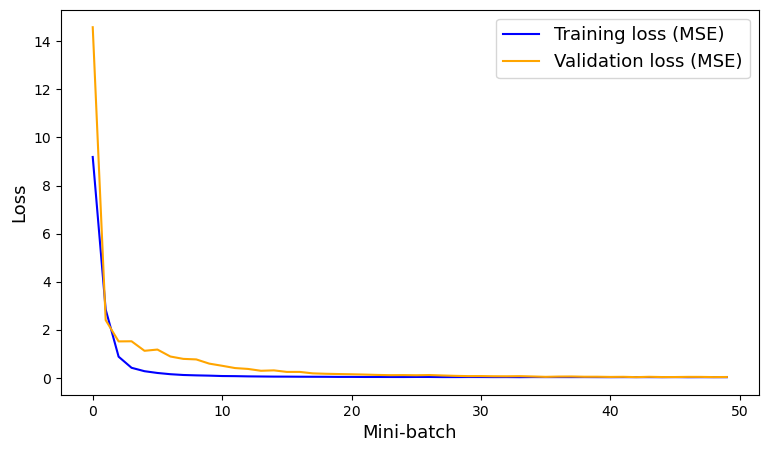

In [103]:
print('')
plt.figure(figsize=(9,5))
plt.plot(RNN_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(RNN_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_error1.eps', format='eps', dpi=1000)
plt.show()

In [104]:
np.random.seed(123)
history_2=LSTM_Model.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=50, verbose=1)

Epoch 1/50
89/89 [==============================] - 17s 73ms/step - loss: 10.1396 - mae: 1.2012 - val_loss: 0.1231 - val_mae: 0.2815
Epoch 2/50
89/89 [==============================] - 5s 60ms/step - loss: 0.0850 - mae: 0.1897 - val_loss: 0.1076 - val_mae: 0.2716
Epoch 3/50
89/89 [==============================] - 6s 66ms/step - loss: 0.0574 - mae: 0.1381 - val_loss: 0.0163 - val_mae: 0.0979
Epoch 4/50
89/89 [==============================] - 6s 69ms/step - loss: 0.0362 - mae: 0.0865 - val_loss: 0.0052 - val_mae: 0.0553
Epoch 5/50
89/89 [==============================] - 5s 59ms/step - loss: 0.0312 - mae: 0.0683 - val_loss: 0.0038 - val_mae: 0.0461
Epoch 6/50
89/89 [==============================] - 6s 69ms/step - loss: 0.0287 - mae: 0.0566 - val_loss: 0.0039 - val_mae: 0.0467
Epoch 7/50
89/89 [==============================] - 5s 61ms/step - loss: 0.0284 - mae: 0.0566 - val_loss: 0.0059 - val_mae: 0.0605
Epoch 8/50
89/89 [==============================] - 6s 65ms/step - loss: 0.0279 -

In [105]:
LSTM_df = pd.DataFrame(history_2.history)
LSTM_df.tail()

,loss,mae,val_loss,val_mae
45,0.024991,0.043077,0.001957,0.034453
46,0.027001,0.060507,0.004503,0.059548
47,0.024796,0.042837,0.003313,0.048589
48,0.024267,0.042676,0.007748,0.079798
49,0.024907,0.050298,0.011943,0.104004


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


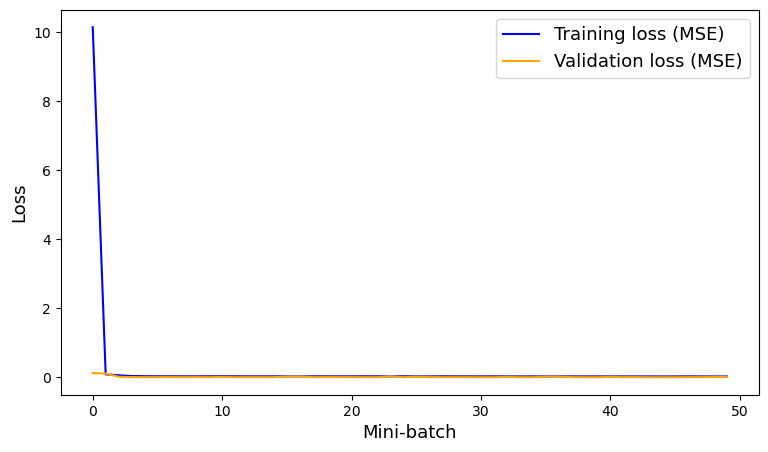

In [106]:
print('')
plt.figure(figsize=(9,5))
plt.plot(LSTM_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(LSTM_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/LSTM_error1.eps', format='eps', dpi=1000)
plt.show()

In [107]:
np.random.seed(123)
history_3=GRU_Model.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=50, verbose=1)

Epoch 1/50
89/89 [==============================] - 21s 77ms/step - loss: 1.4488 - mae: 0.4709 - val_loss: 0.0101 - val_mae: 0.0720
Epoch 2/50
89/89 [==============================] - 5s 54ms/step - loss: 0.0519 - mae: 0.0968 - val_loss: 0.0302 - val_mae: 0.1564
Epoch 3/50
89/89 [==============================] - 5s 59ms/step - loss: 0.0518 - mae: 0.1029 - val_loss: 0.0145 - val_mae: 0.1003
Epoch 4/50
89/89 [==============================] - 5s 60ms/step - loss: 0.0439 - mae: 0.0714 - val_loss: 0.0118 - val_mae: 0.0910
Epoch 5/50
89/89 [==============================] - 5s 58ms/step - loss: 0.0457 - mae: 0.0816 - val_loss: 0.0059 - val_mae: 0.0553
Epoch 6/50
89/89 [==============================] - 5s 57ms/step - loss: 0.0468 - mae: 0.0942 - val_loss: 0.0109 - val_mae: 0.0874
Epoch 7/50
89/89 [==============================] - 5s 60ms/step - loss: 0.0453 - mae: 0.0884 - val_loss: 0.0079 - val_mae: 0.0687
Epoch 8/50
89/89 [==============================] - 5s 56ms/step - loss: 0.0425 - 

In [108]:
GRU_df =pd.DataFrame(history_3.history)
GRU_df.tail()

,loss,mae,val_loss,val_mae
45,0.038320,0.082939,0.005128,0.053986
46,0.036097,0.072690,0.010965,0.088918
47,0.038068,0.077113,0.004710,0.049441
48,0.036552,0.073763,0.009590,0.083046
49,0.035968,0.070854,0.013346,0.100057


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


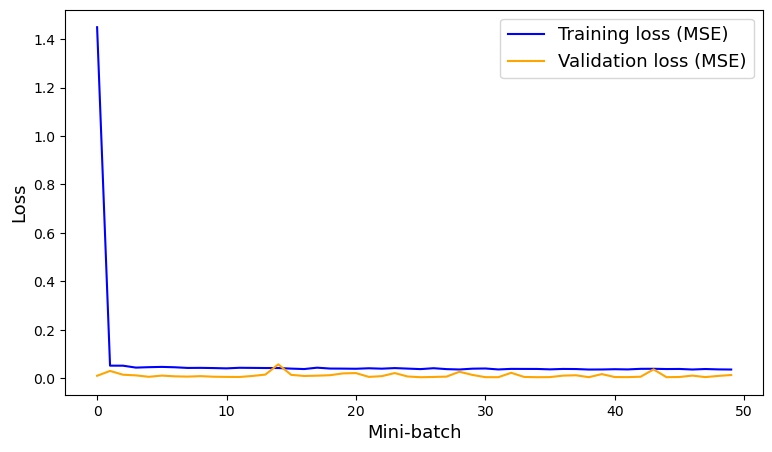

In [109]:
plt.figure(figsize=(9,5))
plt.plot(GRU_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(GRU_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/GRU_error1.eps', format='eps', dpi=1000)
plt.show()

In [110]:
np.random.seed(123)
history_4 = MLP_Model.fit(xtrain, ytrain,
                          epochs=50,
                          validation_data=(xvalid, yvalid))

Epoch 1/50
89/89 [==============================] - 6s 33ms/step - loss: 0.3789 - mae: 0.2682 - val_loss: 0.0189 - val_mae: 0.1289
Epoch 2/50
89/89 [==============================] - 2s 18ms/step - loss: 0.0318 - mae: 0.0615 - val_loss: 0.0157 - val_mae: 0.1176
Epoch 3/50
89/89 [==============================] - 2s 20ms/step - loss: 0.0300 - mae: 0.0630 - val_loss: 0.0104 - val_mae: 0.0936
Epoch 4/50
89/89 [==============================] - 2s 24ms/step - loss: 0.0280 - mae: 0.0606 - val_loss: 0.0017 - val_mae: 0.0293
Epoch 5/50
89/89 [==============================] - 2s 24ms/step - loss: 0.0261 - mae: 0.0531 - val_loss: 0.0031 - val_mae: 0.0455
Epoch 6/50
89/89 [==============================] - 1s 16ms/step - loss: 0.0258 - mae: 0.0565 - val_loss: 0.0039 - val_mae: 0.0530
Epoch 7/50
89/89 [==============================] - 2s 24ms/step - loss: 0.0236 - mae: 0.0412 - val_loss: 0.0037 - val_mae: 0.0523
Epoch 8/50
89/89 [==============================] - 2s 20ms/step - loss: 0.0239 - m

In [111]:
MLP_df =pd.DataFrame(history_4.history)
MLP_df.tail()

,loss,mae,val_loss,val_mae
45,0.023257,0.045688,0.001295,0.024262
46,0.024195,0.052024,0.001913,0.033614
47,0.024089,0.052958,0.001334,0.024912
48,0.024545,0.053397,0.001256,0.023229
49,0.023518,0.046888,0.003097,0.046909


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


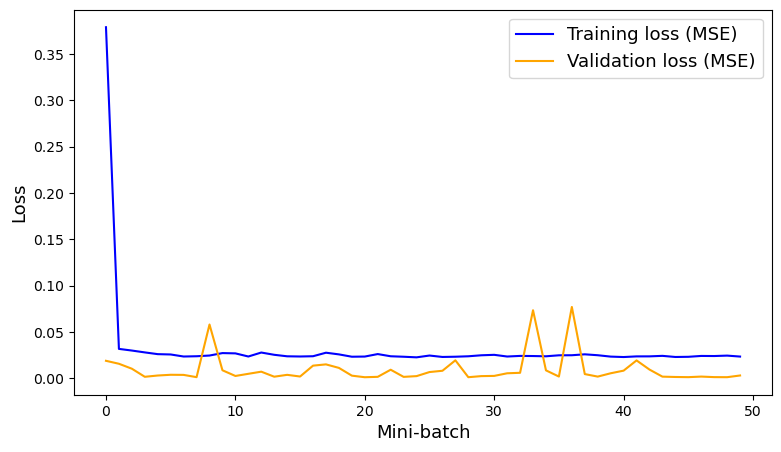

In [112]:
plt.figure(figsize=(9,5))
plt.plot(MLP_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(MLP_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/MLP_Model.eps', format='eps', dpi=1000)
plt.show()

In [113]:
np.random.seed(1)
history_5 = conv1D_Model.fit(xtrain,ytrain,batch_size=300,epochs=50,validation_data=(xvalid,yvalid), verbose = 1)


Epoch 1/50
10/10 [==============================] - 6s 231ms/step - loss: 2.6820 - mae: 1.2438 - val_loss: 0.1420 - val_mae: 0.2196
Epoch 2/50
10/10 [==============================] - 1s 54ms/step - loss: 0.1606 - mae: 0.2939 - val_loss: 0.2088 - val_mae: 0.4031
Epoch 3/50
10/10 [==============================] - 1s 56ms/step - loss: 0.0844 - mae: 0.1826 - val_loss: 0.1580 - val_mae: 0.3412
Epoch 4/50
10/10 [==============================] - 0s 51ms/step - loss: 0.0569 - mae: 0.1270 - val_loss: 0.0453 - val_mae: 0.1708
Epoch 5/50
10/10 [==============================] - 1s 53ms/step - loss: 0.0429 - mae: 0.0831 - val_loss: 0.0101 - val_mae: 0.0845
Epoch 6/50
10/10 [==============================] - 1s 54ms/step - loss: 0.0387 - mae: 0.0615 - val_loss: 0.0048 - val_mae: 0.0544
Epoch 7/50
10/10 [==============================] - 0s 44ms/step - loss: 0.0374 - mae: 0.0502 - val_loss: 0.0032 - val_mae: 0.0418
Epoch 8/50
10/10 [==============================] - 0s 36ms/step - loss: 0.0369 - 

In [114]:
conv1D_df = pd.DataFrame(history_5.history)
conv1D_df.tail()

,loss,mae,val_loss,val_mae
45,0.031817,0.039284,0.002141,0.033404
46,0.031871,0.040410,0.003007,0.043538
47,0.032196,0.047508,0.003301,0.045709
48,0.031729,0.041961,0.001779,0.029116
49,0.031550,0.042839,0.004303,0.055567


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


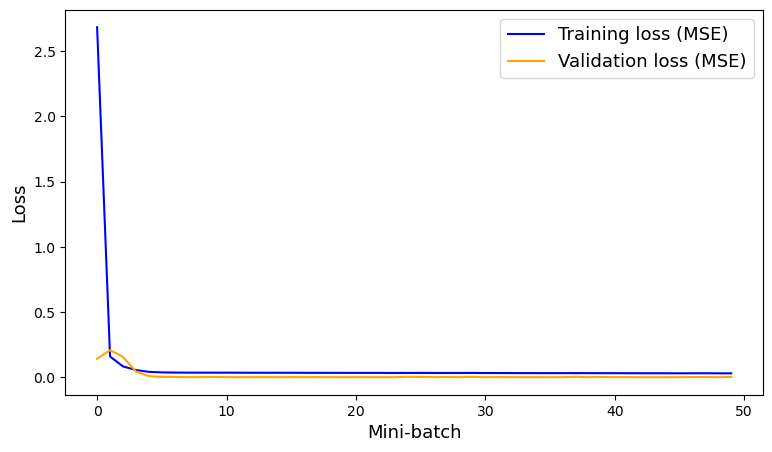

In [115]:
print('')
plt.figure(figsize=(9,5))
plt.plot(conv1D_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(conv1D_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/conv1D_Model.eps', format='eps', dpi=1000)
plt.show()

## Predictions
Now we will use our model to make predictions.

In [117]:
real_pred1 = RNN.predict(xtest)
real_pred2 = LSTM_Model.predict(xtest)
real_pred3 = GRU_Model.predict(xtest)
real_pred4 = MLP_Model.predict(xtest)
real_pred5 = conv1D_Model.predict(xtest)

30/30 [==============================] - 1s 10ms/step


In [118]:
real_pred1.shape,real_pred2.shape,real_pred3.shape,real_pred4.shape,real_pred5.shape

((949, 5, 1), (949, 5, 1), (949, 5, 1), (949, 5, 1), (949, 5, 1))

In [119]:
# Combined Models
Pred_Data = pd.DataFrame({
    'RNN': real_pred1[:,0].flatten(),
    'LSTM': real_pred2[:,0].flatten(),
    'GRU': real_pred3[:,0].flatten(),
    'MLP': real_pred4[:,0,0].flatten(),  # fixed typo here
    'conv1D': real_pred5[:,0].flatten(),  # fixed typo here
    'Actual Price': xtest[:,0].flatten()
})

Pred_Data.head()


,RNN,LSTM,GRU,MLP,conv1D,Actual Price
0,5.786507,6.018982,5.955340,5.964027,5.865553,5.9385
1,5.786510,6.019009,5.920499,5.963865,5.864974,5.8972
2,5.750126,5.973964,5.938331,5.935222,5.855692,5.9183
3,5.741824,5.972258,5.938331,5.920103,5.840901,5.9183
4,5.741381,5.972519,5.938331,5.915889,5.831961,5.9183


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


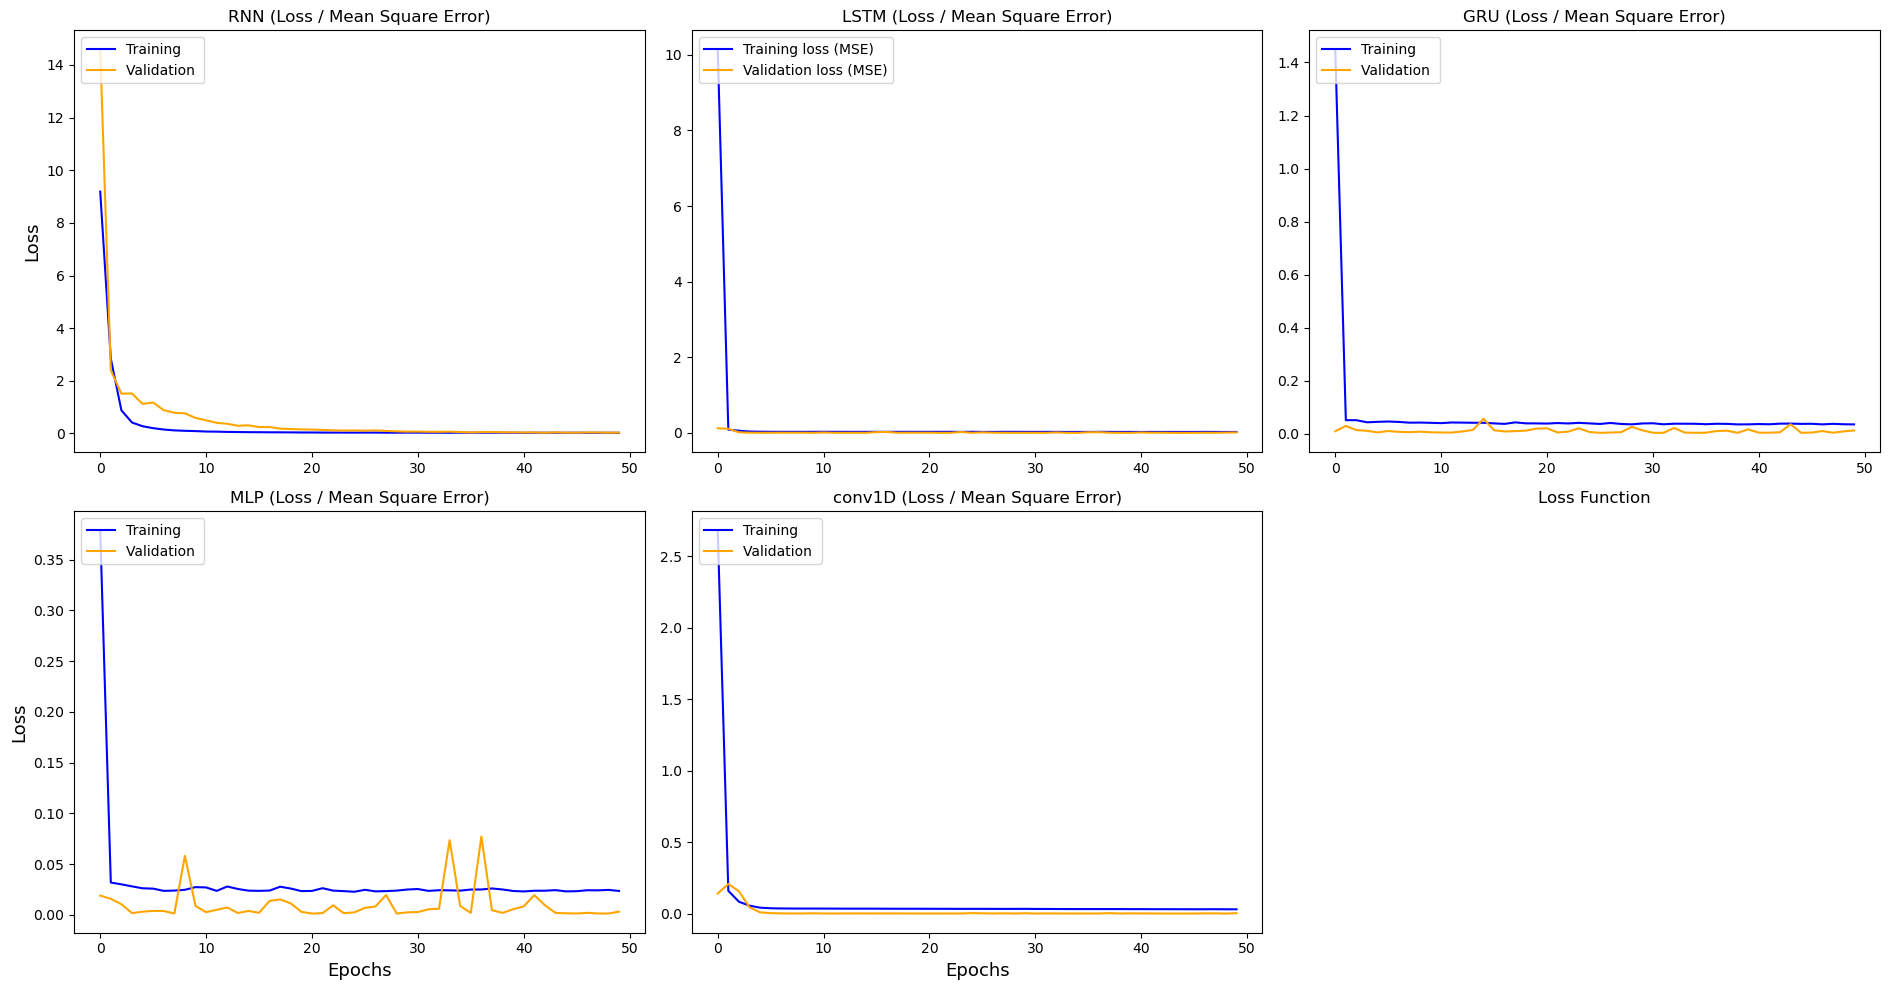

In [120]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(19,10))

axs[0,0].plot(RNN_df['loss'], label ='Training ', color = 'blue')
axs[0,0].plot(RNN_df['val_loss'], label='Validation ', color = 'orange')
axs[0,0].set_title('RNN (Loss / Mean Square Error)')

axs[0,1].plot(LSTM_df['loss'], label ='Training loss (MSE)', color = 'blue')
axs[0,1].plot(LSTM_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
axs[0,1].set_title('LSTM (Loss / Mean Square Error)')

axs[0,2].plot(GRU_df['loss'], label ='Training ', color = 'blue')
axs[0,2].plot(GRU_df['val_loss'], label='Validation ', color = 'orange')
axs[0,2].set_title('GRU (Loss / Mean Square Error)')

axs[1,0].plot(MLP_df['loss'], label ='Training ', color = 'blue')
axs[1,0].plot(MLP_df['val_loss'], label='Validation ', color = 'orange')
axs[1,0].set_title('MLP (Loss / Mean Square Error)')

axs[1,1].plot(conv1D_df['loss'], label ='Training', color = 'blue')
axs[1,1].plot(conv1D_df['val_loss'], label='Validation ', color = 'orange')
axs[1,1].set_title('conv1D (Loss / Mean Square Error)')

axs[1,2].set_title('Loss Function')
# Add a blank subplot to fill the last space in the grid
axs[1,2].axis('off')
#Add legend to all plots
axs[0,0].legend(loc='upper left')
axs[0,1].legend(loc='upper left')
axs[0,2].legend(loc='upper left')
axs[1,0].legend(loc='upper left')
axs[1,1].legend(loc='upper left')
# Add a shared x-axis label to the bottom row of subplots
for ax in axs[1,:]:
    ax.set_xlabel('Epochs', fontsize=13)

# Add a shared y-axis label to the left column of subplots
for ax in axs[:,0]:
    ax.set_ylabel('Loss', fontsize=13)
    


    
plt.tight_layout()
plt.savefig('images/Combined3.eps', format='eps', dpi=1000)
plt.show()


## Combined Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


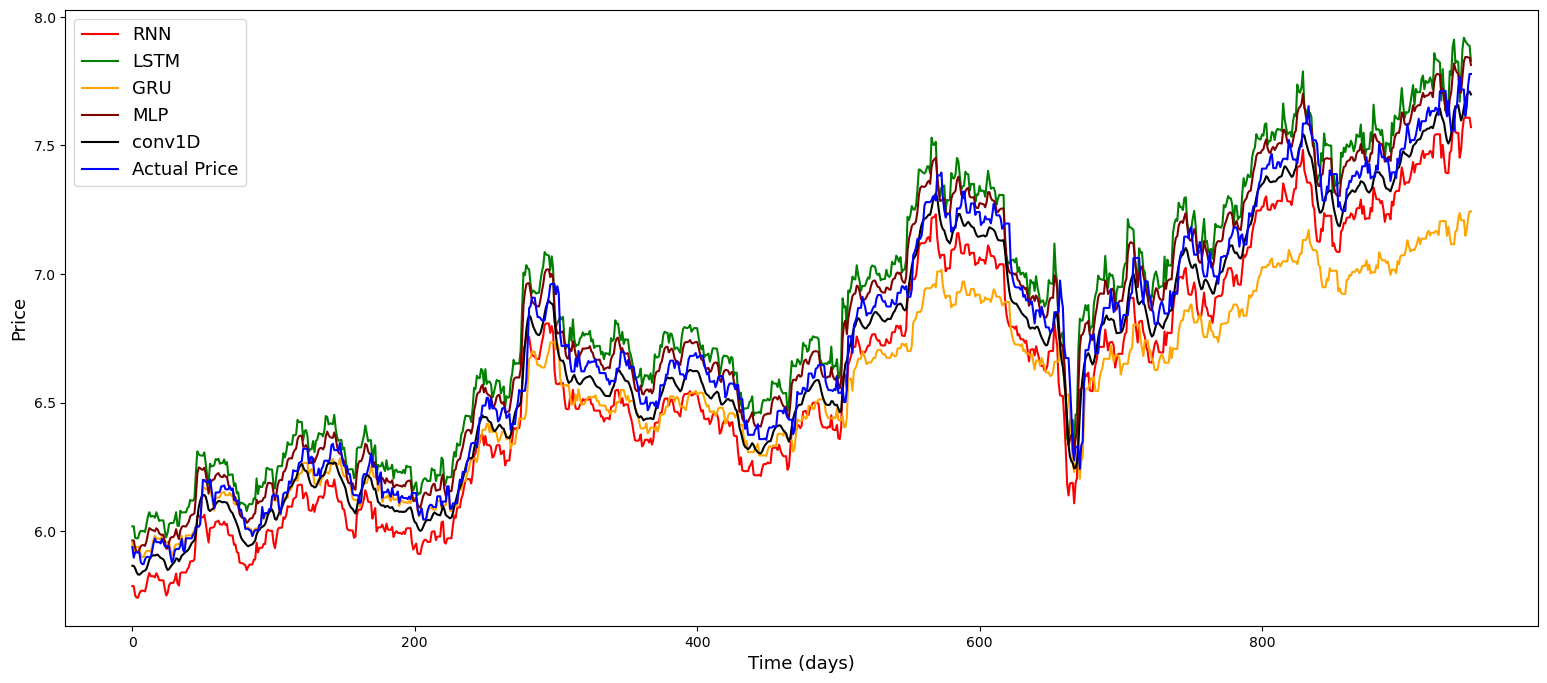

In [122]:

plt.figure(figsize=(19,8))
plt.plot(Pred_Data['RNN'], color = 'red', label = 'RNN')
plt.plot(Pred_Data['LSTM'], color = 'green', label = 'LSTM')
plt.plot(Pred_Data['GRU'], color = 'orange', label = 'GRU')
plt.plot(Pred_Data['MLP'], color = 'maroon', label = 'MLP')
plt.plot(Pred_Data['conv1D'], color = 'black', label = 'conv1D')
plt.plot(xtest[:,0,0].flatten(), color = 'blue', label = 'Actual Price')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/Combined1.eps', format='eps', dpi=1000)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


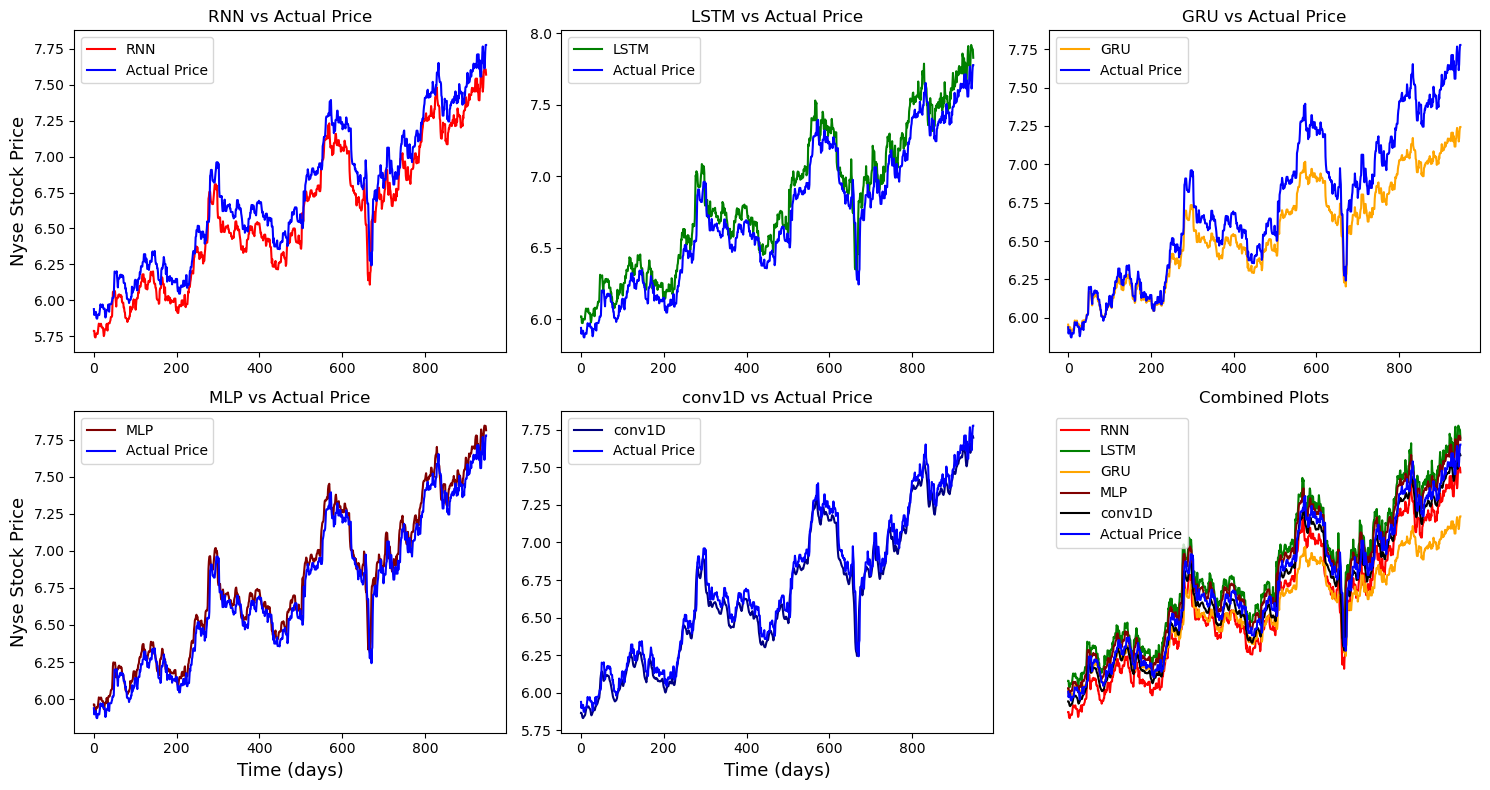

In [123]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

axs[0,0].plot(Pred_Data['RNN'], color='red', label='RNN')
axs[0,0].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Price')
axs[0,0].set_title('RNN vs Actual Price')

axs[0,1].plot(Pred_Data['LSTM'], color='green', label='LSTM')
axs[0,1].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Price')
axs[0,1].set_title('LSTM vs Actual Price')

axs[0,2].plot(Pred_Data['GRU'], color='orange', label='GRU')
axs[0,2].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Price')
axs[0,2].set_title('GRU vs Actual Price')

axs[1,0].plot(Pred_Data['MLP'], color='maroon', label='MLP')
axs[1,0].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Price')
axs[1,0].set_title('MLP vs Actual Price')

axs[1,1].plot(Pred_Data['conv1D'], color='navy', label='conv1D')
axs[1,1].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Price')
axs[1,1].set_title('conv1D vs Actual Price')

axs[1,2].plot(Pred_Data['RNN'], color = 'red', label = 'RNN')
axs[1,2].plot(Pred_Data['LSTM'], color = 'green', label = 'LSTM')
axs[1,2].plot(Pred_Data['GRU'], color = 'orange', label = 'GRU')
axs[1,2].plot(Pred_Data['MLP'], color = 'maroon', label = 'MLP')
axs[1,2].plot(Pred_Data['conv1D'], color = 'black', label = 'conv1D')
axs[1,2].plot(xtest[:,0,0].flatten(), color = 'blue', label = 'Actual Price')

axs[1,2].set_title('Combined Plots')
# Add a blank subplot to fill the last space in the grid
axs[1,2].axis('off')

axs[0,0].legend(loc='upper left')
axs[0,1].legend(loc='upper left')
axs[0,2].legend(loc='upper left')
axs[1,0].legend(loc='upper left')
axs[1,1].legend(loc='upper left')
axs[1,2].legend(loc='upper left')
# Add a shared x-axis label to the bottom row of subplots
for ax in axs[1,:]:
    ax.set_xlabel('Time (days)', fontsize=13)

# Add a shared y-axis label to the left column of subplots
for ax in axs[:,0]:
    ax.set_ylabel('Nyse Stock Price', fontsize=13)
    

plt.tight_layout()
plt.savefig('images/Combined2.eps', format='eps', dpi=1000)
plt.show()


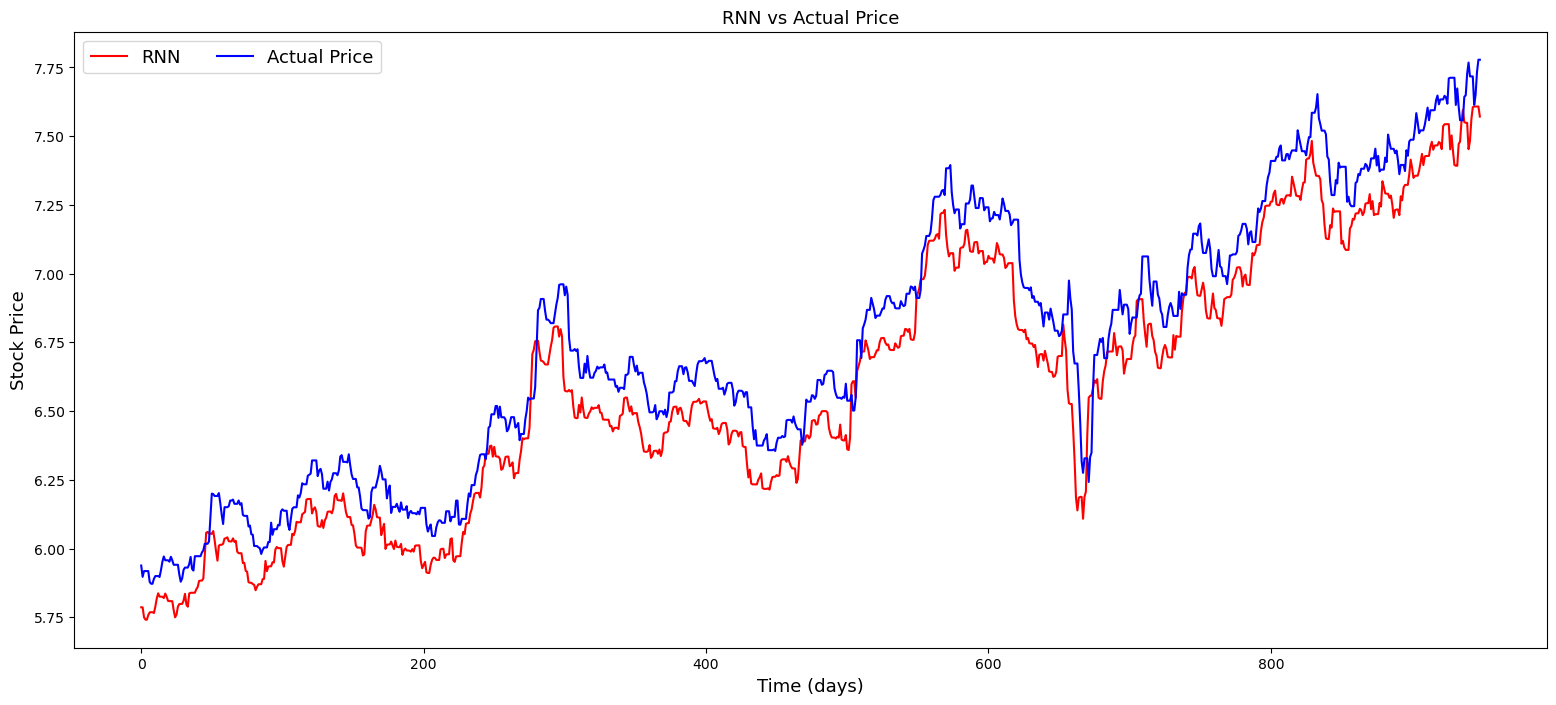

In [124]:
plt.figure(figsize=(19,8))
plt.plot(Pred_Data['RNN'], color='red', label='RNN')
plt.plot(xtest[:,0,0].flatten(), color='blue', label='Actual Price')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.title('RNN vs Actual Price', fontsize=13)
plt.legend(fontsize=13,loc='upper left', ncol=2)
plt.show()


In [125]:
# Assuming xtest is the test data and has shape (num_samples, num_timesteps, num_features)
rnn_pred = RNN.predict(xtest)
lstm_pred = LSTM_Model.predict(xtest)
gru_pred = GRU_Model.predict(xtest)
mlp_pred = MLP_Model.predict(xtest)
conv1d_pred = conv1D_Model.predict(xtest)


30/30 [==============================] - 0s 12ms/step


In [126]:
rnn_pred.shape,lstm_pred.shape,gru_pred.shape,mlp_pred.shape,conv1d_pred.shape

((949, 5, 1), (949, 5, 1), (949, 5, 1), (949, 5, 1), (949, 5, 1))

In [137]:
# Evaluate RNN predictions
rnn_mae = mean_absolute_error(ytest, rnn_pred)
rnn_mse = mean_squared_error(ytest, rnn_pred)
rnn_rmse = np.sqrt(rnn_mse)
rnn_r2 = r2_score(ytest, rnn_pred)

# Evaluate LSTM predictions
lstm_mae = mean_absolute_error(ytest, lstm_pred)
lstm_mse = mean_squared_error(ytest, lstm_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(ytest, lstm_pred)

# Evaluate GRU predictions
gru_mae = mean_absolute_error(ytest, gru_pred)
gru_mse = mean_squared_error(ytest, gru_pred)
gru_rmse = np.sqrt(gru_mse)
gru_r2 = r2_score(ytest, gru_pred)

# Evaluate MLP predictions
mlp_mae = mean_absolute_error(ytest, mlp_pred)
mlp_mse = mean_squared_error(ytest, mlp_pred)
mlp_rmse = np.sqrt(mlp_mse)
mlp_r2 = r2_score(ytest, mlp_pred)

# Evaluate Conv1D predictions
conv1d_mae = mean_absolute_error(ytest, conv1d_pred)
conv1d_mse = mean_squared_error(ytest, conv1d_pred)
conv1d_rmse = np.sqrt(conv1d_mse)
conv1d_r2 = r2_score(ytest, conv1d_pred)


ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
print("RNN Evaluation Metrics:")
print(f"MAE: {rnn_mae:.4f}, MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}, R2: {rnn_r2:.4f}\n")

print("LSTM Evaluation Metrics:")
print(f"MAE: {lstm_mae:.4f}, MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, R2: {lstm_r2:.4f}\n")

print("GRU Evaluation Metrics:")
print(f"MAE: {gru_mae:.4f}, MSE: {gru_mse:.4f}, RMSE: {gru_rmse:.4f}, R2: {gru_r2:.4f}\n")

print("MLP Evaluation Metrics:")
print(f"MAE: {mlp_mae:.4f}, MSE: {mlp_mse:.4f}, RMSE: {mlp_rmse:.4f}, R2: {mlp_r2:.4f}\n")

print("Conv1D Evaluation Metrics:")
print(f"MAE: {conv1d_mae:.4f}, MSE: {conv1d_mse:.4f}, RMSE: {conv1d_rmse:.4f}, R2: {conv1d_r2:.4f}\n")


In [ ]:
import pandas as pd

# Create a DataFrame with evaluation metrics
results = pd.DataFrame({'MAE': [rnn_mae, lstm_mae, gru_mae, mlp_mae, conv1d_mae],
                        'MSE': [rnn_mse, lstm_mse, gru_mse, mlp_mse, conv1d_mse],
                        'RMSE': [rnn_rmse, lstm_rmse, gru_rmse, mlp_rmse, conv1d_rmse],
                        'R2': [rnn_r2, lstm_r2, gru_r2, mlp_r2, conv1d_r2]},
                       index=['RNN', 'LSTM', 'GRU', 'MLP', 'Conv1D'])
